## Analysis for glutamate imaging

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
from pathlib import Path
vol_file = '../Voltron_data/SnFR_Log_DRN_Exp.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/SnFRData/'
dir_folder = Path(dat_folder)

In [3]:
frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16
color_list = ['k', 'r', 'b']

## Swim only visual only

/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice.
/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.


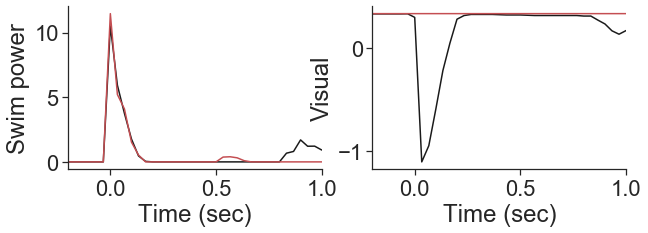

['05022019', 'Fish1-1-swimonly_visualonly']


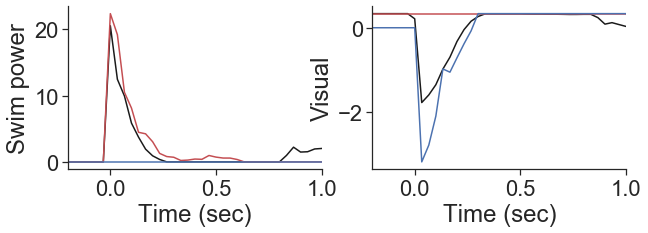

['05022019', 'Fish1-2-swimonly_visualonly']


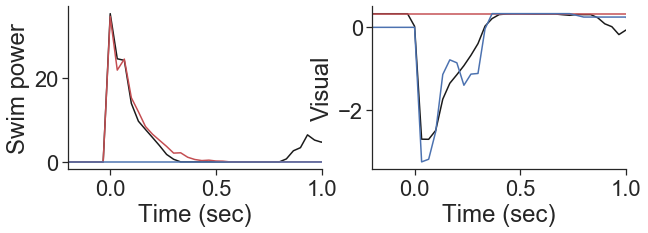

['05022019', 'Fish1-3-swimonly_visualonly']


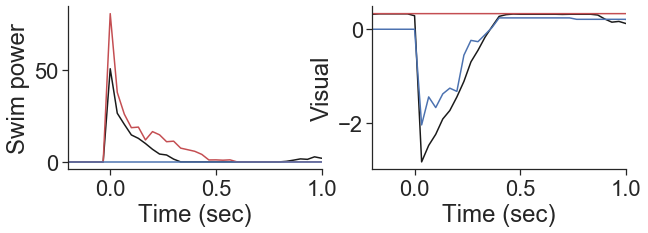

['05082019', 'Fish1-1-swimonly_visualonly']


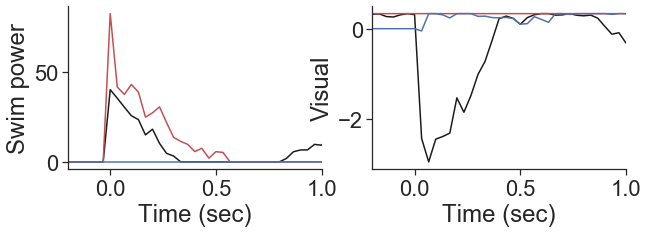

['05092019', 'Fish1-3-swimonly_visualonly']


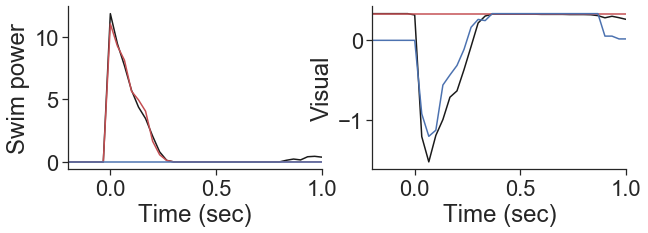

['05092019', 'Fish2-1-swimonly_visualonly']


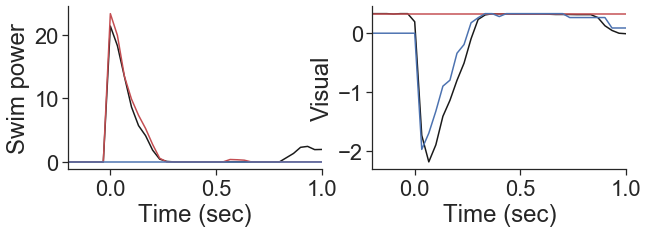

['05092019', 'Fish2-2-swimonly_visualonly']


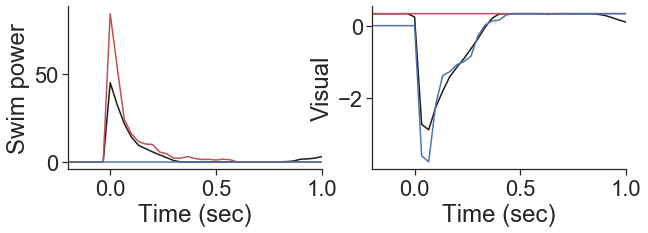

['05092019', 'Fish2-3-swimonly_visualonly']


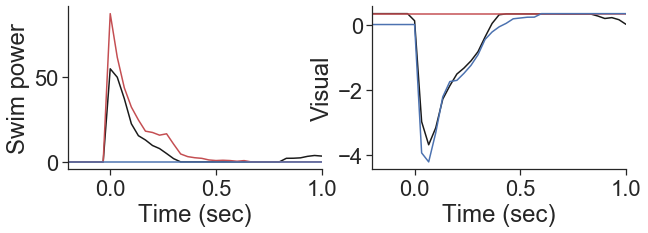

['05092019', 'Fish2-4-swimonly_visualonly']


In [18]:
t_pre = 10 # time window pre-swim
t_post = 35 # time window post-swim
t_label = np.arange(-t_pre, t_post)/30
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
t_swim_CL = t_pre + 10
t_swim_OL = t_pre + 20
t_len = t_pre+t_post

for ind, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Swimonly_Visualonly':
        continue
    if row['area'] != 'Glu':
        continue
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    if not os.path.exists(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz'):
        continue
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)    
    task_period = _['swim_task_index'].astype('int')            
    # _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    trial_valid = np.ones(len(p_swim)).astype('bool')
    swim_power_thres = np.percentile(p_swim[(task_period==1) & trial_valid].mean(axis=0), 99)
    
    trial_pre = (p_swim[:, :t_pre]>0).sum(axis=-1)==0
    trial_valid_CL = (p_swim[:, t_swim_CL:t_swim_CL+15]>0).sum(axis=-1)==0
    trial_valid_CL = trial_valid_CL & trial_pre
    trial_valid_OL = ((visu.max(axis=-1, keepdims=True)-visu)[:, :-5]>0).sum(axis=-1)==0
    trial_valid_OL = trial_valid_OL & (p_swim[:, t_swim_CL:t_pre+30].max(axis=-1)<swim_power_thres)
    trial_valid_OL = trial_valid_OL & trial_pre
    trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_pre+30]>1).sum(axis=-1)==0)
    trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_swim_OL+15]>0).sum(axis=-1)==0)
    trial_valid_VL = (p_swim[:, t_pre:t_pre+30]>0).sum(axis=-1)==0
    trial_valid_VL = trial_valid_VL & (visu[:, t_swim_OL:t_pre+300].min(axis=-1)>=0)
    trial_valid_VL = trial_valid_VL & trial_pre
    
    if np.percentile(p_swim[(task_period==2) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
                
    if ((task_period==2) & trial_valid & trial_valid_OL).sum()<5:
        continue

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.flatten()
    
    for n in range(3):
        if n==0:
            trial_valid_ = trial_valid & trial_valid_CL
        if n==1:
            trial_valid_ = trial_valid & trial_valid_OL
        if n==2:
            trial_valid_ = trial_valid & trial_valid_VL
        ax[0].plot(t_label, p_swim[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        ax[1].plot(t_label, visu[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('Swim power')
    ax[0].set_xlim([-0.2, 1.0])
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Visual')
    ax[1].set_xlim([-0.2, 1.0])
    sns.despine()
    plt.show()
    print([folder, fish])

/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice.
/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice.


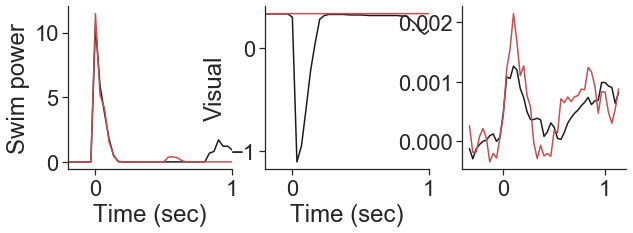

['05022019', 'Fish1-1-swimonly_visualonly']


/groups/ahrens/home/weiz/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice.


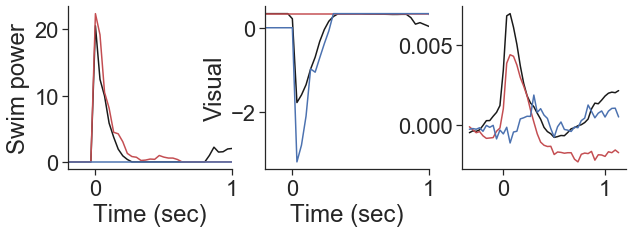

['05022019', 'Fish1-2-swimonly_visualonly']


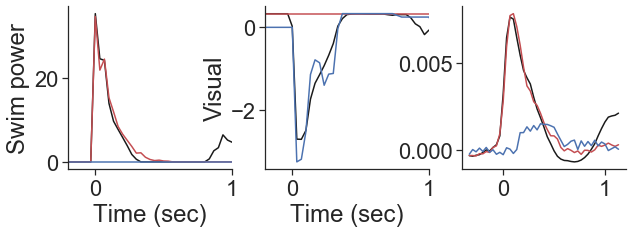

['05022019', 'Fish1-3-swimonly_visualonly']


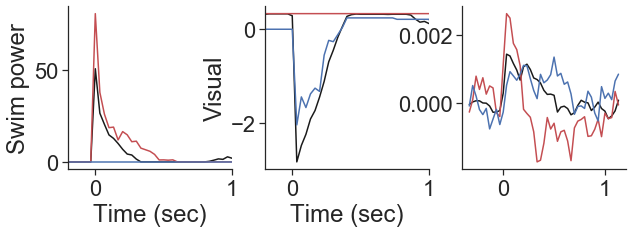

['05082019', 'Fish1-1-swimonly_visualonly']


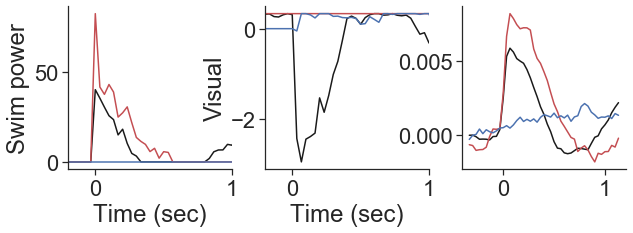

['05092019', 'Fish1-3-swimonly_visualonly']


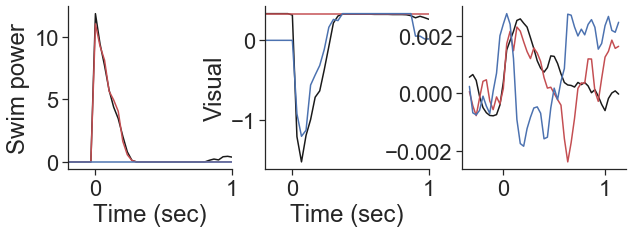

['05092019', 'Fish2-1-swimonly_visualonly']


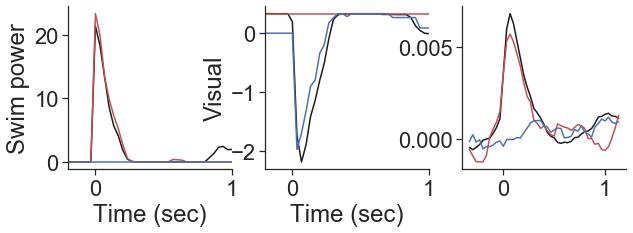

['05092019', 'Fish2-2-swimonly_visualonly']


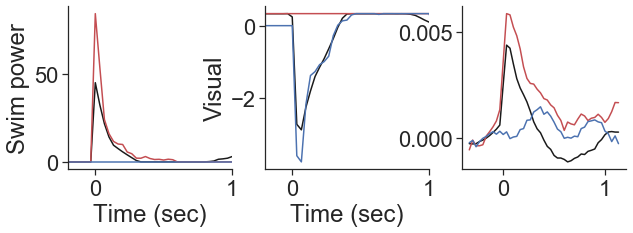

['05092019', 'Fish2-3-swimonly_visualonly']


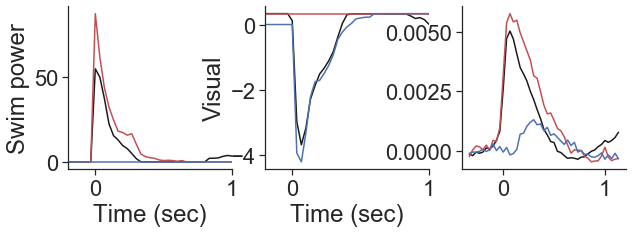

['05092019', 'Fish2-4-swimonly_visualonly']


In [20]:
t_pre = 10 # time window pre-swim
t_post = 35 # time window post-swim
t_label = np.arange(-t_pre, t_post)/30
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
t_swim_CL = t_pre + 10
t_swim_OL = t_pre + 20
t_len = t_pre+t_post

for ind, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Swimonly_Visualonly':
        continue
    if row['area'] != 'Glu':
        continue
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    rootDir = row['rootDir']
    img_dir = rootDir+f'{folder}/{fish}/Registered'
    dff_dir = dat_folder+f'{folder}/{fish}/Data/'
    if not os.path.exists(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz'):
        continue
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    swim_starts = _['swim_starts']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)    
    task_period = _['swim_task_index'].astype('int')            
    # _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    trial_valid = np.ones(len(p_swim)).astype('bool')
    swim_power_thres = np.percentile(p_swim[(task_period==1) & trial_valid].mean(axis=0), 99)
    
    trial_pre = (p_swim[:, :t_pre]>0).sum(axis=-1)==0
    trial_valid_CL = (p_swim[:, t_swim_CL:t_swim_CL+15]>0).sum(axis=-1)==0
    trial_valid_CL = trial_valid_CL & trial_pre
    trial_valid_OL = ((visu.max(axis=-1, keepdims=True)-visu)[:, :-5]>0).sum(axis=-1)==0
    trial_valid_OL = trial_valid_OL & (p_swim[:, t_swim_CL:t_pre+30].max(axis=-1)<swim_power_thres)
    trial_valid_OL = trial_valid_OL & trial_pre
    trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_pre+30]>1).sum(axis=-1)==0)
    trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_swim_OL+15]>0).sum(axis=-1)==0)
    trial_valid_VL = (p_swim[:, t_pre:t_pre+30]>0).sum(axis=-1)==0
    trial_valid_VL = trial_valid_VL & (visu[:, t_swim_OL:t_pre+300].min(axis=-1)>=0)
    trial_valid_VL = trial_valid_VL & trial_pre
    
    dFF = np.load(img_dir+'/dFF_sub.npy')[()]
    dim = dFF.shape
    dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels
    ave = np.load(img_dir+'/stack_sub.npy')[()]
    ave = ave.mean(axis=0).reshape((1,dim[1]*dim[2]),order='F')
    include_pix=np.where(ave>150)[1]
    dFF = dFF[:, include_pix].mean(axis=-1)
    n_pix = dFF.shape[-1]
    dff_ = np.zeros((len(swim_starts), t_len))
    
    for ns, s in enumerate(swim_starts):
        dff_[ns] = dFF[(s-t_pre):(s+t_post)] - dFF[(s-t_flat):s].mean(axis=0, keepdims=True)
    
    if np.percentile(p_swim[(task_period==2) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
                
    if ((task_period==2) & trial_valid & trial_valid_OL).sum()<5:
        continue

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax = ax.flatten()
    
    for n in range(3):
        if n==0:
            trial_valid_ = trial_valid & trial_valid_CL
        if n==1:
            trial_valid_ = trial_valid & trial_valid_OL
        if n==2:
            trial_valid_ = trial_valid & trial_valid_VL
        ax[0].plot(t_label, p_swim[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        ax[1].plot(t_label, visu[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        ax[2].plot(t_label, dff_[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('Swim power')
    ax[0].set_xlim([-0.2, 1.0])
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Visual')
    ax[1].set_xlim([-0.2, 1.0])
    sns.despine()
    plt.show()
    print([folder, fish])